In [21]:
#we define an "incremented pd_code" if it is of the form (a, b, a+1, b+1) or (a, b+1, a+1, b). This is achieved by walking around the knot and labelling each new 'strand'
#with an incrementing indexing number as you pass over or under a crossing.

#method for getting an incremented pd code of a knot as a list. sage takes pd_code lists as inputs for knots.
def knot_from_table(k,n):
    import snappy
    def sage_pd_code(link):
        pd = link.PD_code()
        return [[element + 1 for element in tup] for tup in pd]
    L = snappy.Link(str(k) + '_' + str(n))
    snappd = sage_pd_code(L)
    print(snappd)
    K = Knot(snappd)
    return K

#returns the list of regions with no negative values.
def abs_regions(self):
    regions = self.regions()
    return [set(abs(element) for element in reg) for reg in regions]

#returns the pd_code as a set. Used supplementarily to aid in intersection and difference checks.
def cross(self):
    return [set(pd) for pd in self.pd_code()]


def weight(tuple):
    if int(tuple[0]) % 2 == 1:
        return +1
    else:
        return -1

#returns the complement of two sets' intersection.
def complement_intersection(set1, set2):
    return set(set1).difference(set2)

#returns the length of the intersection of two sets. used primarily for the weights of the crossings, as a set is unordered.
def common_elements(lst, s):
    list_set = set(lst)
    common = list_set.intersection(s)
    return len(common)

#quick graph
def decorate_and_plot_graph(g):
    plot = g.plot(layout = 'spring', dist = 0.15, iterations = 200, edge_labels=True)
    plot.show(figsize = 6)

def knot_type(pd_code):
    Z2_list = [[p % 2 for p in c] for c in pd_code]
    typeI = [[0, 0, 1, 1], [1, 1, 0, 0]]
    typeII = [[0,1,1,0],[1,0,0,1]]
    if all(c in typeI for c in Z2_list) == True:
        return 'TypeI'
    else:
        zero_count = sum(1 for t in Z2_list if t == typeII[0])
        print(f"There are {zero_count} crossings of the form [0,1,1,0]")
        one_count = sum(1 for t in Z2_list if t == typeII[1])
        print(f"There are {one_count} crossings of the form [1,0,0,1]")
        return Z2_list

In [22]:
import sage.graphs.graph as graph

def tait_graph(K):
    regions = abs_regions(K)
    crossings = cross(K)
    pd_code = K.pd_code()
    #print(pd_code)
    #print(crossings)
    #print(abs_regions(K))
    faces_static = {index: tuple(region) for index, region in enumerate(regions)}
    faces = {tuple(region): index for index, region in enumerate(regions)}
    #print(faces)
    print(faces_static)
    edges = []
    seen = []
    #seen_weights = []
    for ind in range(len(faces)):
        common_list = [c for c in crossings if len(set(faces_static[ind]).intersection(c)) == 2]

        weight_check = [p for p in pd_code for c in common_list if common_elements(p,c) == 4]

        common_list_weights = [weight(p) for p in weight_check]

        """
        for p in weight_check:
            seen_weights.append(p)
        """

        #print(common_list)
        #print(len(common_list) == len(common_list_weights))
        set_diff = [complement_intersection(c, faces_static[ind]) for c in common_list]

        neighboring_regions = [
            (key, value)
            for key, value in faces_static.items()
            for s in set_diff if len(set(value).intersection(s)) == 2
        ]

        #print(neighboring_regions)
        for i in range(len(neighboring_regions)):
            if neighboring_regions[i][1] not in seen:
                edges.append((faces[faces_static[ind]], neighboring_regions[i][0], common_list_weights[i]))
        seen.append(faces_static[ind])
        #print(seen)
        #print(f"edges = {edges}")
    
    G = graph.Graph(edges, multiedges=True)
    components = G.connected_components()
    if len(components) > 2:
        raise ValueError('The link diagram is split.')
    return G.subgraph(components[0]), G.subgraph(components[1])
    

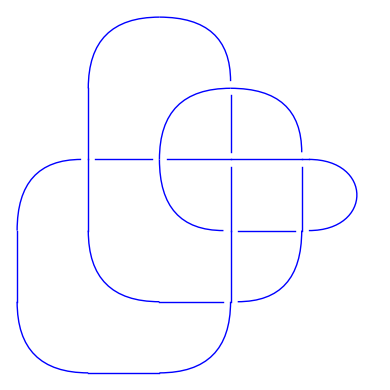

[[16, 6, 1, 5], [6, 2, 7, 1], [11, 3, 12, 2], [3, 15, 4, 14], [4, 10, 5, 9], [12, 8, 13, 7], [8, 14, 9, 13], [15, 11, 16, 10]]
[[16, 6, 2, -11], [15, 11, 3], [14, -3, 12, 8], [13, -8], [10, -15, 4], [9, -4, -14], [7, -12, -2], [5, -16, -10], [1, -6], [-1, -5, -9, -13, -7]]
{0: (16, 2, 11, 6), 1: (3, 11, 15), 2: (8, 3, 12, 14), 3: (8, 13), 4: (10, 4, 15), 5: (9, 4, 14), 6: (2, 12, 7), 7: (16, 10, 5), 8: (1, 6), 9: (1, 5, 7, 9, 13)}


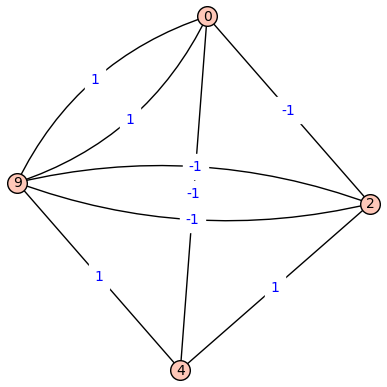

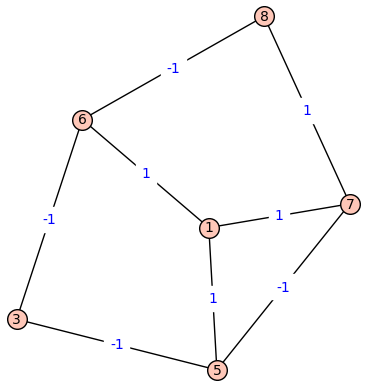

In [48]:
K = knot_from_table(8,19)
K.plot().show()
print(K.pd_code())
print(K.regions())
black, white = tait_graph(K)

decorate_and_plot_graph(white)
decorate_and_plot_graph(black)

In [8]:
import pandas as pd
from sage.graphs.graph import Graph
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import ast

def decorate_and_plot_graph(edges, name):
    G = Graph(edges, multiedges = True)
    # SageMath plots can be saved to a file instead of a Matplotlib figure
    plot_file = f"/tmp/{name}.png"
    G.plot(layout='spring', dist=0.15, iterations=200, edge_labels=False, title=str(name)).save(plot_file)
    return plot_file

def save_all_graphs_to_pdf(csv_file, output_pdf):
    # Read the CSV file
    df = pd.read_csv(csv_file, delimiter=';')
    
    # Create a PdfPages object to save all plots in a single PDF
    with PdfPages(output_pdf) as pdf:
        # Iterate through the rows of the DataFrame
        for index, row in df.iterrows():
            name = row['Name']
            edges = ast.literal_eval(row['edge_graph'])  # Convert string representation of list to list
            
            # Generate and save the plot
            plot_file = decorate_and_plot_graph(edges, name)
            
            # Read the saved plot into Matplotlib and save to PDF
            img = plt.imread(plot_file)
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.imshow(img)
            ax.axis('off')  # Hide axes
            pdf.savefig(fig)  # Save the current figure into the PDF
            plt.close(fig)  # Close the figure to free up memory

# Usage
csv_file = '/root/Desktop/REU2024/knot_info_inc_PD_with_edge_graphs.csv'  # Path to your CSV file
output_pdf = '/root/Desktop/all_graphs.pdf'  # Path to the output PDF file
save_all_graphs_to_pdf(csv_file, output_pdf)